# Hitter Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
# import plotly.express as px

### Set up dataframe

In [ ]:
# import data 
df = pd.read_csv('savant_data_6_hitters.csv')

# clean df by eliminating rows where game_pk and pitch_type is missing
df.dropna(subset=['game_pk', 'pitch_type'], inplace=True)

# fix up column datatypes
df['game_pk'] = df['game_pk'].astype(int) # to get rid of the *.0
df['game_pk'] = df['game_pk'].astype(str)
df['sv_id'] = df['sv_id'].astype(str)
df['pitcher'] = df['pitcher'].astype(int) # to get rid of the *.0
df['pitcher'] = df['pitcher'].astype(str)
df['batter'] = df['batter'].astype(int) # to get rid of the *.0
df['batter'] = df['batter'].astype(str)

# switch from catcher's perspective to pitcher's perspective
# Catcher's POV: (plate_x,plate_z)
# Pitcher's POV: (plate_-x,plate_z)
df['plate_-x'] = -df['plate_x']

# create unique pitch_id
df['pitch_id'] = df['game_pk'] + " " + df['sv_id']

# show data 
#df.head()
#list(df.columns.values)

In [4]:
# make new dataframe with less info
df_pitch_coords = df[['game_pk','sv_id','pitch_id','batter','stand','pitcher','pitch_type','release_speed',
                      'description','events','plate_x','plate_-x','plate_z', 'sz_top','sz_bot']]

## TODO clean up by eliminating non-swing hits?

df_pitch_coords.head(10)
df_pitch_coords.dtypes

game_pk           object
sv_id             object
pitch_id          object
batter            object
stand             object
pitcher            int64
pitch_type        object
release_speed    float64
description       object
events            object
plate_x          float64
plate_-x         float64
plate_z          float64
sz_top           float64
sz_bot           float64
dtype: object

In [5]:
# sets of unique batter ids
left_hitters = set()
right_hitters = set()
for row in range(df_pitch_coords.shape[0]):
    batter_id = df_pitch_coords.iloc[row]['batter']
    batter_stand = df_pitch_coords.iloc[row]['stand']
    
    if batter_stand == 'L':
        #if batter_id not in left_hitters:
        left_hitters.add(batter_id)
    if batter_stand == 'R':
        #if batter_id not in right_hitters:
        right_hitters.add(batter_id)

switch_hitters = left_hitters & right_hitters

print("Left Hitters")
print(left_hitters)
print()
print("Right Hitters")
print(right_hitters)
print()
print("Switch Hitters")
print(switch_hitters)

Left Hitters
{'592885', '641355'}

Right Hitters
{'641313', '660670', '593160', '545361'}

Switch Hitters
set()


### Show all pitches in scatter plot 

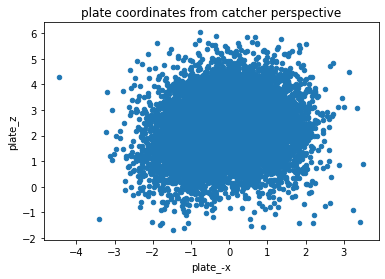

In [6]:
all_pitches_plot = df_pitch_coords.plot(kind='scatter', x='plate_-x', y='plate_z',
                           title='plate coordinates from catcher perspective')
# center of plate at ground = (0,0)

all_pitches_plot

### Calculate what zone a pitch falls into

In [7]:
def det_batter_zone(x,z,sz_top,sz_bot):
    sz_mid = ((sz_top - sz_bot)/2) + sz_bot
    sz_third = (sz_top - sz_bot)/3
    # non-competitive pitches
    if (z < 1) or (z > 4) or (x < -1.5) or (x > 1.5):
        return 0 
    # inner strikezone (1-9)
    elif (sz_bot <= z) and (z <= sz_top) and (-0.7 <= x) and (x <= 0.7):
        if (sz_top >= z) and (z > (sz_top-sz_third)):
            if (x <= -0.23):
                return 1
            elif (x <= 0.23):
                return 2
            elif (x <= 0.7):
                  return 3
        elif ((sz_top-sz_third) >= z) and (z > (sz_bot+sz_third)):
            if (x <= -0.23):
                return 4
            elif (x <= 0.23):
                return 5
            elif (x <= 0.7):
                return 6
        elif ((sz_bot+sz_third) >= z) and (z >= sz_bot):
            if (x <= -0.23):
                return 7
            elif (x <= 0.23):
                return 8
            elif (x <= 0.7):
                return 9
    # outer strike zone
    # top row (10-13)
    elif (sz_top < z) and (z <= 4) and (-1.5 <= x) and (x <= 1.5):
        if (x <= -0.7):
            return 10
        elif (x <= 0):
            return 11
        elif (x <= 0.7):
            return 12
        elif (x <= 1.5):
            return 13
    # top middle row (14,15)
    elif (sz_mid < z) and (z <= sz_top):
        if (-1.5 <= x) and (-0.7 > x):
            return 14
        elif (0.7 < x) and (x <= 1.5):
            return 15
    # bottom middle row (16,17)
    elif (sz_bot < z) and (z <= sz_mid):
        if (-1.5 <= x) and (-0.7 > x):
            return 16
        elif (0.7 < x) and (x <= 1.5):
            return 17
    # bottom row (18-21)
    elif (1 <= z) and (z <= sz_bot) and (-1.5 <= x) and (x <= 1.5):
        if (x <= -0.7):
            return 18
        elif (x <= 0):
            return 19
        elif (x <= 0.7):
            return 20
        elif (x <= 1.5):
            return 21
    # null or invalid
    return -1 

### Measure success of pitch type per zone per batter 

* batters is dictionary that maps batter id to zones list
    * zones is list that maps zone num (index) to pitch_types dictionary
        * pitch_types is dictionary that maps type of pitch to counters for hits, fouls, strikes, and total pitches

In [8]:
batters = {}
for row in range(df_pitch_coords.shape[0]):
    pitch_zone = det_batter_zone(df_pitch_coords.iloc[row]['plate_-x'],
                          df_pitch_coords.iloc[row]['plate_z'],
                          df_pitch_coords.iloc[row]['sz_top'],
                          df_pitch_coords.iloc[row]['sz_bot'])
  
    if (pitch_zone != -1): # don't include null or invalid pitches in zone -1
        batter_id = df_pitch_coords.iloc[row]['batter']
        pitch_type = df_pitch_coords.iloc[row]['pitch_type']
        pitch_event = df_pitch_coords.iloc[row]['events']
        pitch_result = df_pitch_coords.iloc[row]['description']
        pitch_speed = df_pitch_coords.iloc[row]['release_speed']

        # initialize new batter
        if batter_id not in batters:
            batters[batter_id] = [] # init empty zones list
            for z in range(22): # 22 zones (0: noncompetitive, 1-21: strikezone)
                pitch_types = {}
                batters[batter_id].insert(z, pitch_types)
        # initialize new pitch_type 
        if pitch_type not in batters[batter_id][pitch_zone]:
            batters[batter_id][pitch_zone][pitch_type] = [] #todo: maybe dict?
            for c in range(5): # num of counters
                if c == 0:
                    batters[batter_id][pitch_zone][pitch_type].insert(c, 0)
                else:
                    batters[batter_id][pitch_zone][pitch_type].insert(c, [0, 0])

        # Add to counters:
        
        # swing and miss
        if pitch_result in ('swinging_strike', 'swinging_strike_blocked'):
            batters[batter_id][pitch_zone][pitch_type][0] += 1 # total
            batters[batter_id][pitch_zone][pitch_type][1][0] += 1 # total misses
            batters[batter_id][pitch_zone][pitch_type][1][1] += pitch_speed
        # swing and foul
        elif pitch_result in ('foul', 'foul_tip'): # foul (runner going) ???
            batters[batter_id][pitch_zone][pitch_type][0] += 1 # total
            batters[batter_id][pitch_zone][pitch_type][2][0] += 1 # total fouls
            batters[batter_id][pitch_zone][pitch_type][2][1] += pitch_speed
         # swing and hit
        elif pitch_result in ('hit_into_play', 'hit_into_play_no_out', 'hit_into_play_score'):
            # made contact and obtained a hit
            if pitch_event in ('single', 'double', 'triple', 'home_run'):
                batters[batter_id][pitch_zone][pitch_type][0] += 1 # total
                batters[batter_id][pitch_zone][pitch_type][3][0] += 1 # total contact to hit
                batters[batter_id][pitch_zone][pitch_type][3][1] += pitch_speed
            # made contact and obtained an out
            elif pitch_event not in ('single', 'double', 'triple', 'home_run'):
                batters[batter_id][pitch_zone][pitch_type][0] += 1 # total
                batters[batter_id][pitch_zone][pitch_type][4][0] += 1 # total contact to out
                batters[batter_id][pitch_zone][pitch_type][4][1] += pitch_speed
        # else: # batter didn't swing

In [9]:
def get_color_speed(pitch_count_list):
    # total is when batter swung
    total = pitch_count_list[0]
    # misses
    num_misses = pitch_count_list[1][0]
    sum_speed_misses = pitch_count_list[1][1]
    # fouls
    num_fouls = pitch_count_list[2][0]
    sum_speed_fouls = pitch_count_list[2][1]
    # contact to hits
    num_contact_to_hits = pitch_count_list[3][0]
    sum_speed_hits = pitch_count_list[3][1]
    # contact to outs
    num_contact_to_outs = pitch_count_list[4][0]
    sum_speed_outs = pitch_count_list[4][1]
    
    color = None
    speed = None
    if total > 5:
        if (num_contact_to_hits / total) > 0.33:
            color = "red"
            speed = sum_speed_hits // num_contact_to_hits
            int(speed)
        elif((num_fouls + num_misses) / total) > 0.8:
            color = "green"
            speed = (sum_speed_fouls + sum_speed_misses) // (num_fouls + num_misses)
            int(speed)
        elif((num_contact_to_outs + num_fouls + num_misses) / total) > 0.75:
            color = "yellow"
            speed = (sum_speed_outs + sum_speed_fouls + sum_speed_misses) // (num_contact_to_outs + num_fouls + num_misses)
            int(speed)
    return (color, speed)

In [10]:
# for b in batters:    
#     for z in range(22):
#         for p in batters[b][z]:
#             batters[b][z][p].insert(5,get_color_speed(batters[b][z][p]))

#print(batters)
for b in batters:    
    for z in range(22):
        for p in batters[b][z]:
            batters[b][z][p].insert(5,get_color_speed(batters[b][z][p]))

{'641355': [{'FF': [16, [9, 838.2], [6, 568.8000000000001], [0, 0], [1, 94.2]], 'CH': [7, [6, 499.3], [1, 84.4], [0, 0], [0, 0]], 'FT': [1, [0, 0], [1, 95.2], [0, 0], [0, 0]], 'KC': [1, [1, 82.2], [0, 0], [0, 0], [0, 0]], 'CU': [3, [3, 249.1], [0, 0], [0, 0], [0, 0]], 'SL': [6, [5, 426.59999999999997], [1, 84.7], [0, 0], [0, 0]], 'FC': [3, [1, 89.2], [2, 175.9], [0, 0], [0, 0]], 'SI': [0, [0, 0], [0, 0], [0, 0], [0, 0]], 'FS': [0, [0, 0], [0, 0], [0, 0], [0, 0]], 'KN': [0, [0, 0], [0, 0], [0, 0], [0, 0]]}, {'FT': [4, [0, 0], [2, 187.3], [1, 95.5], [1, 93.6]], 'SI': [4, [1, 95.3], [2, 186.7], [1, 91.7], [0, 0]], 'FF': [36, [6, 563.5999999999999], [21, 1942.2000000000003], [3, 249.9], [6, 551.6]], 'CU': [0, [0, 0], [0, 0], [0, 0], [0, 0]], 'FC': [4, [0, 0], [1, 83.6], [0, 0], [3, 268.4]], 'SL': [2, [1, 84.8], [0, 0], [0, 0], [1, 85.1]], 'CH': [1, [0, 0], [1, 85.4], [0, 0], [0, 0]], 'KC': [0, [0, 0], [0, 0], [0, 0], [0, 0]]}, {'CU': [2, [1, 86.2], [0, 0], [0, 0], [1, 81.3]], 'FT': [1, [0,

In [17]:
# print(batters)

### Data Set With Relevant Info for JSON

In [12]:
# with open("6_hitters_all.json", "w") as hitters_file:
#     json.dump(batters, hitters_file, sort_keys=True, indent=2)

In [9]:
simplified_batters = {}
for b in batters:
    simplified_batters[b] = []
    for z in range(22):
        pitch_types = {}
        simplified_batters[b].insert(z, pitch_types)
        for p in batters[b][z]:
            #simplified_batters[b][z][p] = get_color_speed(batters[b][z][p])
            color, avg_speed = get_color_speed(batters[b][z][p])
            if (color != None) and (avg_speed != None):
                simplified_batters[b][z][p] = (color, avg_speed)
    
print(simplified_batters)

NameError: name 'batters' is not defined

In [14]:
# with open("6_hitters_simp.json", "w") as hitters_file:
#     json.dump(simplified_batters, hitters_file, sort_keys=True, indent=2)

### Sanity Check for colors of pitch types in zone for batter

In [15]:
# for b in batters:
print("Cody Bellinger 2019 Season")
bellinger = '641355'
print()
for z in range(22):
    print("Zone %s" %z)
    red_pitch_types = []
    yellow_pitch_types = []
    green_pitch_types = []

    for p in batters[bellinger][z]:
        # color = batters[bellinger][z][p][5][0]
        # avg_speed = batters[bellinger][z][p][5][1]
        color, avg_speed = get_color_speed(batters[bellinger][z][p])
        if color == 'red':
            red_pitch_types.append((p, int(avg_speed)))
        elif color == 'yellow':
            yellow_pitch_types.append((p, int(avg_speed)))
        elif color == 'green':
            green_pitch_types.append((p, int(avg_speed)))

    print("Red: " + str(red_pitch_types))
    print("Yellow: " + str(yellow_pitch_types))
    print("Green: " + str(green_pitch_types))
    print()

Cody Bellinger 2019 Season

Zone 0
Red: []
Yellow: []
Green: [('FF', 93), ('CH', 83), ('SL', 85)]

Zone 1
Red: []
Yellow: [('FF', 92)]
Green: []

Zone 2
Red: []
Yellow: [('FF', 94)]
Green: []

Zone 3
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 4
Red: []
Yellow: [('SL', 86), ('FF', 94), ('SI', 92), ('FC', 88)]
Green: []

Zone 5
Red: []
Yellow: [('FF', 93), ('SL', 85), ('CH', 87), ('SI', 92)]
Green: []

Zone 6
Red: [('SL', 85), ('CH', 88)]
Yellow: [('FF', 94)]
Green: [('FT', 93)]

Zone 7
Red: []
Yellow: [('SL', 85), ('CH', 84), ('CU', 79), ('FT', 92)]
Green: []

Zone 8
Red: []
Yellow: [('FF', 93), ('CH', 86), ('FT', 93), ('SI', 91), ('SL', 84)]
Green: []

Zone 9
Red: []
Yellow: [('SL', 84), ('CH', 86), ('FF', 94), ('FC', 89), ('FT', 93)]
Green: []

Zone 10
Red: []
Yellow: []
Green: []

Zone 11
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 12
Red: [('FF', 92)]
Yellow: []
Green: []

Zone 13
Red: []
Yellow: []
Green: []

Zone 14
Red: []
Yellow: [('FF', 93)]
Green: []

Zone 15
Red: [('CH', 8